# Import Dependencies

In [ ]:
import os
import json
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = model.to(device)


Using device: cuda


# Load Data

In [ ]:
with open("train.json", "r") as f:
    train_data = json.load(f)
with open("dev.json", "r") as f:
    dev_data = json.load(f)


# Create Embedding

In [ ]:
# Use sentence-transformers for semantic similarity
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_embedding(sample):
    text = " ".join([sample['precontext'], sample['sentence'], sample.get('ending','')])
    return embed_model.encode(text)

for dataset in [train_data, dev_data]:
    for sample in dataset.values():
        sample['embedding'] = compute_embedding(sample)


# Model Definition

In [ ]:

model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Prompt Creation

In [ ]:
def build_zero_shot_prompt(sample):
    return f"""
Please rate the plausibility of the meaning of the word in context. Return only a number from 1 to 5.

Context:
{sample['precontext']} {sample['sentence']} {sample.get('ending','')}

Word: "{sample['homonym']}"
Meaning: "{sample['judged_meaning']}"
"""

def build_few_shot_prompt(sample, few_examples):
    prompt = "Rate the plausibility of a word's meaning in context (1-5). Only return a number.\n\n"

    for ex in few_examples:
        prompt += f"Context: {ex['precontext']} {ex['sentence']} {ex.get('ending','')}\n"
        prompt += f"Word: \"{ex['homonym']}\", Meaning: \"{ex['judged_meaning']}\"\n"
        prompt += f"Correct answer: {round(ex['average'])}\n---\n"

    prompt += f"\nContext: {sample['precontext']} {sample['sentence']} {sample.get('ending','')}\n"
    prompt += f"Word: \"{sample['homonym']}\", Meaning: \"{sample['judged_meaning']}\"\n"
    prompt += "Return only a number from 1 to 5."

    return prompt


In [ ]:
def select_few_shot_examples(sample, train_data, n=3):
    sample_emb = sample['embedding'].reshape(1, -1)
    sims = []
    for s in train_data.values():
        sim = cosine_similarity(sample_emb, s['embedding'].reshape(1, -1))[0][0]
        sims.append((sim, s))
    sims.sort(key=lambda x: x[0], reverse=True)
    return [s for _, s in sims[:n]]


# Model Prediction

In [ ]:
def get_model_prediction(sample, few_shot=False, n_few=3):
    few_examples = select_few_shot_examples(sample, train_data, n=n_few) if few_shot else []

    prompt = build_few_shot_prompt(sample, few_examples) if few_shot else build_zero_shot_prompt(sample)

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
    output_ids = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=20,
        do_sample=False
    )

    pred_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Numeric extraction (digits or words)
    number_words = {"one":1, "two":2, "three":3, "four":4, "five":5}
    try:
        pred_score = int([s for s in pred_text if s in "12345"][0])
    except IndexError:
        pred_text_lower = pred_text.lower()
        for word, val in number_words.items():
            if word in pred_text_lower:
                pred_score = val
                break
        else:
            pred_score = 3

    return pred_score


In [ ]:
# Zero-shot
zero_shot_predictions = {}
for i, (id_str, sample) in enumerate(dev_data.items(), 1):
    pred = get_model_prediction(sample, few_shot=False)
    zero_shot_predictions[id_str] = pred
    print(f"[Zero-shot {i}/{len(dev_data)}] Sample {id_str}, prediction: {pred}")



[Zero-shot 1/588] Sample 0, prediction: 1
[Zero-shot 2/588] Sample 1, prediction: 3
[Zero-shot 3/588] Sample 2, prediction: 1
[Zero-shot 4/588] Sample 3, prediction: 3
[Zero-shot 5/588] Sample 4, prediction: 1
[Zero-shot 6/588] Sample 5, prediction: 3
[Zero-shot 7/588] Sample 6, prediction: 1
[Zero-shot 8/588] Sample 7, prediction: 1
[Zero-shot 9/588] Sample 8, prediction: 1
[Zero-shot 10/588] Sample 9, prediction: 1
[Zero-shot 11/588] Sample 10, prediction: 1
[Zero-shot 12/588] Sample 11, prediction: 1
[Zero-shot 13/588] Sample 12, prediction: 1
[Zero-shot 14/588] Sample 13, prediction: 1
[Zero-shot 15/588] Sample 14, prediction: 1
[Zero-shot 16/588] Sample 15, prediction: 1
[Zero-shot 17/588] Sample 16, prediction: 1
[Zero-shot 18/588] Sample 17, prediction: 1
[Zero-shot 19/588] Sample 18, prediction: 3
[Zero-shot 20/588] Sample 19, prediction: 3
[Zero-shot 21/588] Sample 20, prediction: 3
[Zero-shot 22/588] Sample 21, prediction: 3
[Zero-shot 23/588] Sample 22, prediction: 3
[Zero-s

In [ ]:
# Few-shot
few_shot_predictions = {}
for i, (id_str, sample) in enumerate(dev_data.items(), 1):
    pred = get_model_prediction(sample, few_shot=True)
    few_shot_predictions[id_str] = pred
    print(f"[Few-shot {i}/{len(dev_data)}] Sample {id_str}, prediction: {pred}")

[Few-shot 1/588] Sample 0, prediction: 3
[Few-shot 2/588] Sample 1, prediction: 3
[Few-shot 3/588] Sample 2, prediction: 3
[Few-shot 4/588] Sample 3, prediction: 3
[Few-shot 5/588] Sample 4, prediction: 3
[Few-shot 6/588] Sample 5, prediction: 3
[Few-shot 7/588] Sample 6, prediction: 2
[Few-shot 8/588] Sample 7, prediction: 1
[Few-shot 9/588] Sample 8, prediction: 2
[Few-shot 10/588] Sample 9, prediction: 1
[Few-shot 11/588] Sample 10, prediction: 3
[Few-shot 12/588] Sample 11, prediction: 1
[Few-shot 13/588] Sample 12, prediction: 3
[Few-shot 14/588] Sample 13, prediction: 3
[Few-shot 15/588] Sample 14, prediction: 3
[Few-shot 16/588] Sample 15, prediction: 1
[Few-shot 17/588] Sample 16, prediction: 3
[Few-shot 18/588] Sample 17, prediction: 3
[Few-shot 19/588] Sample 18, prediction: 3
[Few-shot 20/588] Sample 19, prediction: 3
[Few-shot 21/588] Sample 20, prediction: 3
[Few-shot 22/588] Sample 21, prediction: 3
[Few-shot 23/588] Sample 22, prediction: 3
[Few-shot 24/588] Sample 23, p

# Model Evaluation

In [ ]:
def get_average(l): return sum(l)/len(l)
def get_standard_deviation(l): return statistics.stdev(l) if len(l)>1 else 0

def is_within_standard_deviation(pred, labels):
    avg = get_average(labels)
    stdev = get_standard_deviation(labels)
    if stdev==0: return pred==avg
    return (avg-stdev)<=pred<=(avg+stdev) or abs(avg-pred)<1

def evaluate_regression(predictions, gold_data):
    gold_list, pred_list = [], []
    correct, total = 0, 0
    errors = []

    for id_str, pred in predictions.items():
        labels = gold_data[id_str]['choices']
        avg = get_average(labels)
        gold_list.append(avg)
        pred_list.append(pred)
        if is_within_standard_deviation(pred, labels):
            correct += 1
        else:
            errors.append((id_str, pred, avg))
        total += 1

    corr, _ = spearmanr(pred_list, gold_list)
    accuracy = correct/total
    mse = mean_squared_error(gold_list, pred_list)
    mae = mean_absolute_error(gold_list, pred_list)
    return corr, accuracy, mse, mae, errors


In [ ]:
# Zero-shot
corr_zs, acc_zs, mse_zs, mae_zs, errors_zs = evaluate_regression(zero_shot_predictions, dev_data)
print(f"Zero-shot: Spearman={corr_zs:.4f}, Accuracy={acc_zs:.4f}, MSE={mse_zs:.4f}, MAE={mae_zs:.4f}")

# Few-shot
corr_fs, acc_fs, mse_fs, mae_fs, errors_fs = evaluate_regression(few_shot_predictions, dev_data)
print(f"Few-shot: Spearman={corr_fs:.4f}, Accuracy={acc_fs:.4f}, MSE={mse_fs:.4f}, MAE={mae_fs:.4f}")


Zero-shot: Spearman=0.0479, Accuracy=0.4626, MSE=2.7227, MAE=1.3502
Few-shot: Spearman=0.0654, Accuracy=0.5425, MSE=1.5225, MAE=1.0467


In [ ]:
def plot_results(predictions, gold_data, title="Predictions vs Gold", save_path="plots/results.png",
                 spearman=None, accuracy=None, mse=None, mae=None):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    dev_df_plot = pd.DataFrame.from_dict(gold_data, orient="index")
    dev_df_plot['numeric_score'] = [predictions[k] for k in gold_data.keys()]
    dev_df_plot['error'] = np.abs(dev_df_plot['numeric_score'] - dev_df_plot['average'])

    if 'std' not in dev_df_plot.columns:
        dev_df_plot['std'] = [sample.get('std', 0) for sample in gold_data.values()]
    if 'homonym' not in dev_df_plot.columns:
        dev_df_plot['homonym'] = [sample['homonym'] for sample in gold_data.values()]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=300)

    # 1. Predictions vs Actual
    sc = axes[0,0].scatter(dev_df_plot['average'], dev_df_plot['numeric_score'],
                           alpha=0.5, c=dev_df_plot['std'], cmap='viridis',
                           s=30, edgecolors='black', linewidth=0.5)
    axes[0,0].plot([1,5],[1,5],'r--', linewidth=2, label='Perfect')
    axes[0,0].set_xlabel('Actual Rating', weight='bold')
    axes[0,0].set_ylabel('Predicted Rating', weight='bold')
    axes[0,0].set_title(title, weight='bold')
    axes[0,0].legend()
    plt.colorbar(sc, ax=axes[0,0], label='Human StdDev')
    axes[0,0].grid(True, alpha=0.3)

    # 2. Error distribution
    axes[0,1].hist(dev_df_plot['error'], bins=30, color='#4C72B0', edgecolor='black', alpha=0.7)
    axes[0,1].axvline(dev_df_plot['error'].mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {dev_df_plot["error"].mean():.3f}')
    axes[0,1].set_xlabel('Absolute Error', weight='bold')
    axes[0,1].set_ylabel('Frequency', weight='bold')
    axes[0,1].set_title('Error Distribution', weight='bold')
    axes[0,1].legend()
    axes[0,1].grid(axis='y', alpha=0.3)

    # 3. Challenging vs Other homonyms
    CHALLENGING_HOMONYMS = ['potential','base','lead','spring']
    challenging_errors = dev_df_plot[dev_df_plot['homonym'].isin(CHALLENGING_HOMONYMS)]['error']
    other_errors = dev_df_plot[~dev_df_plot['homonym'].isin(CHALLENGING_HOMONYMS)]['error']
    axes[1,0].boxplot([challenging_errors, other_errors], labels=['Challenging','Others'])
    axes[1,0].set_ylabel('Absolute Error', weight='bold')
    axes[1,0].set_title('Error by Homonym Type', weight='bold')
    axes[1,0].grid(True, alpha=0.3)

    # 4. Summary
    axes[1,1].axis('off')
    summary_text = f"""
TOTAL DEV SAMPLES: {len(dev_df_plot)}

Spearman Correlation: {spearman:.4f}
Mean Absolute Error: {mae:.4f}
Accuracy: {accuracy:.4f}
MSE: {mse:.4f}
"""
    axes[1,1].text(0.05, 0.5, summary_text, fontsize=12, family='monospace', verticalalignment='center')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


/tmp/ipython-input-1325784111.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot([challenging_errors, other_errors], labels=['Challenging','Others'])


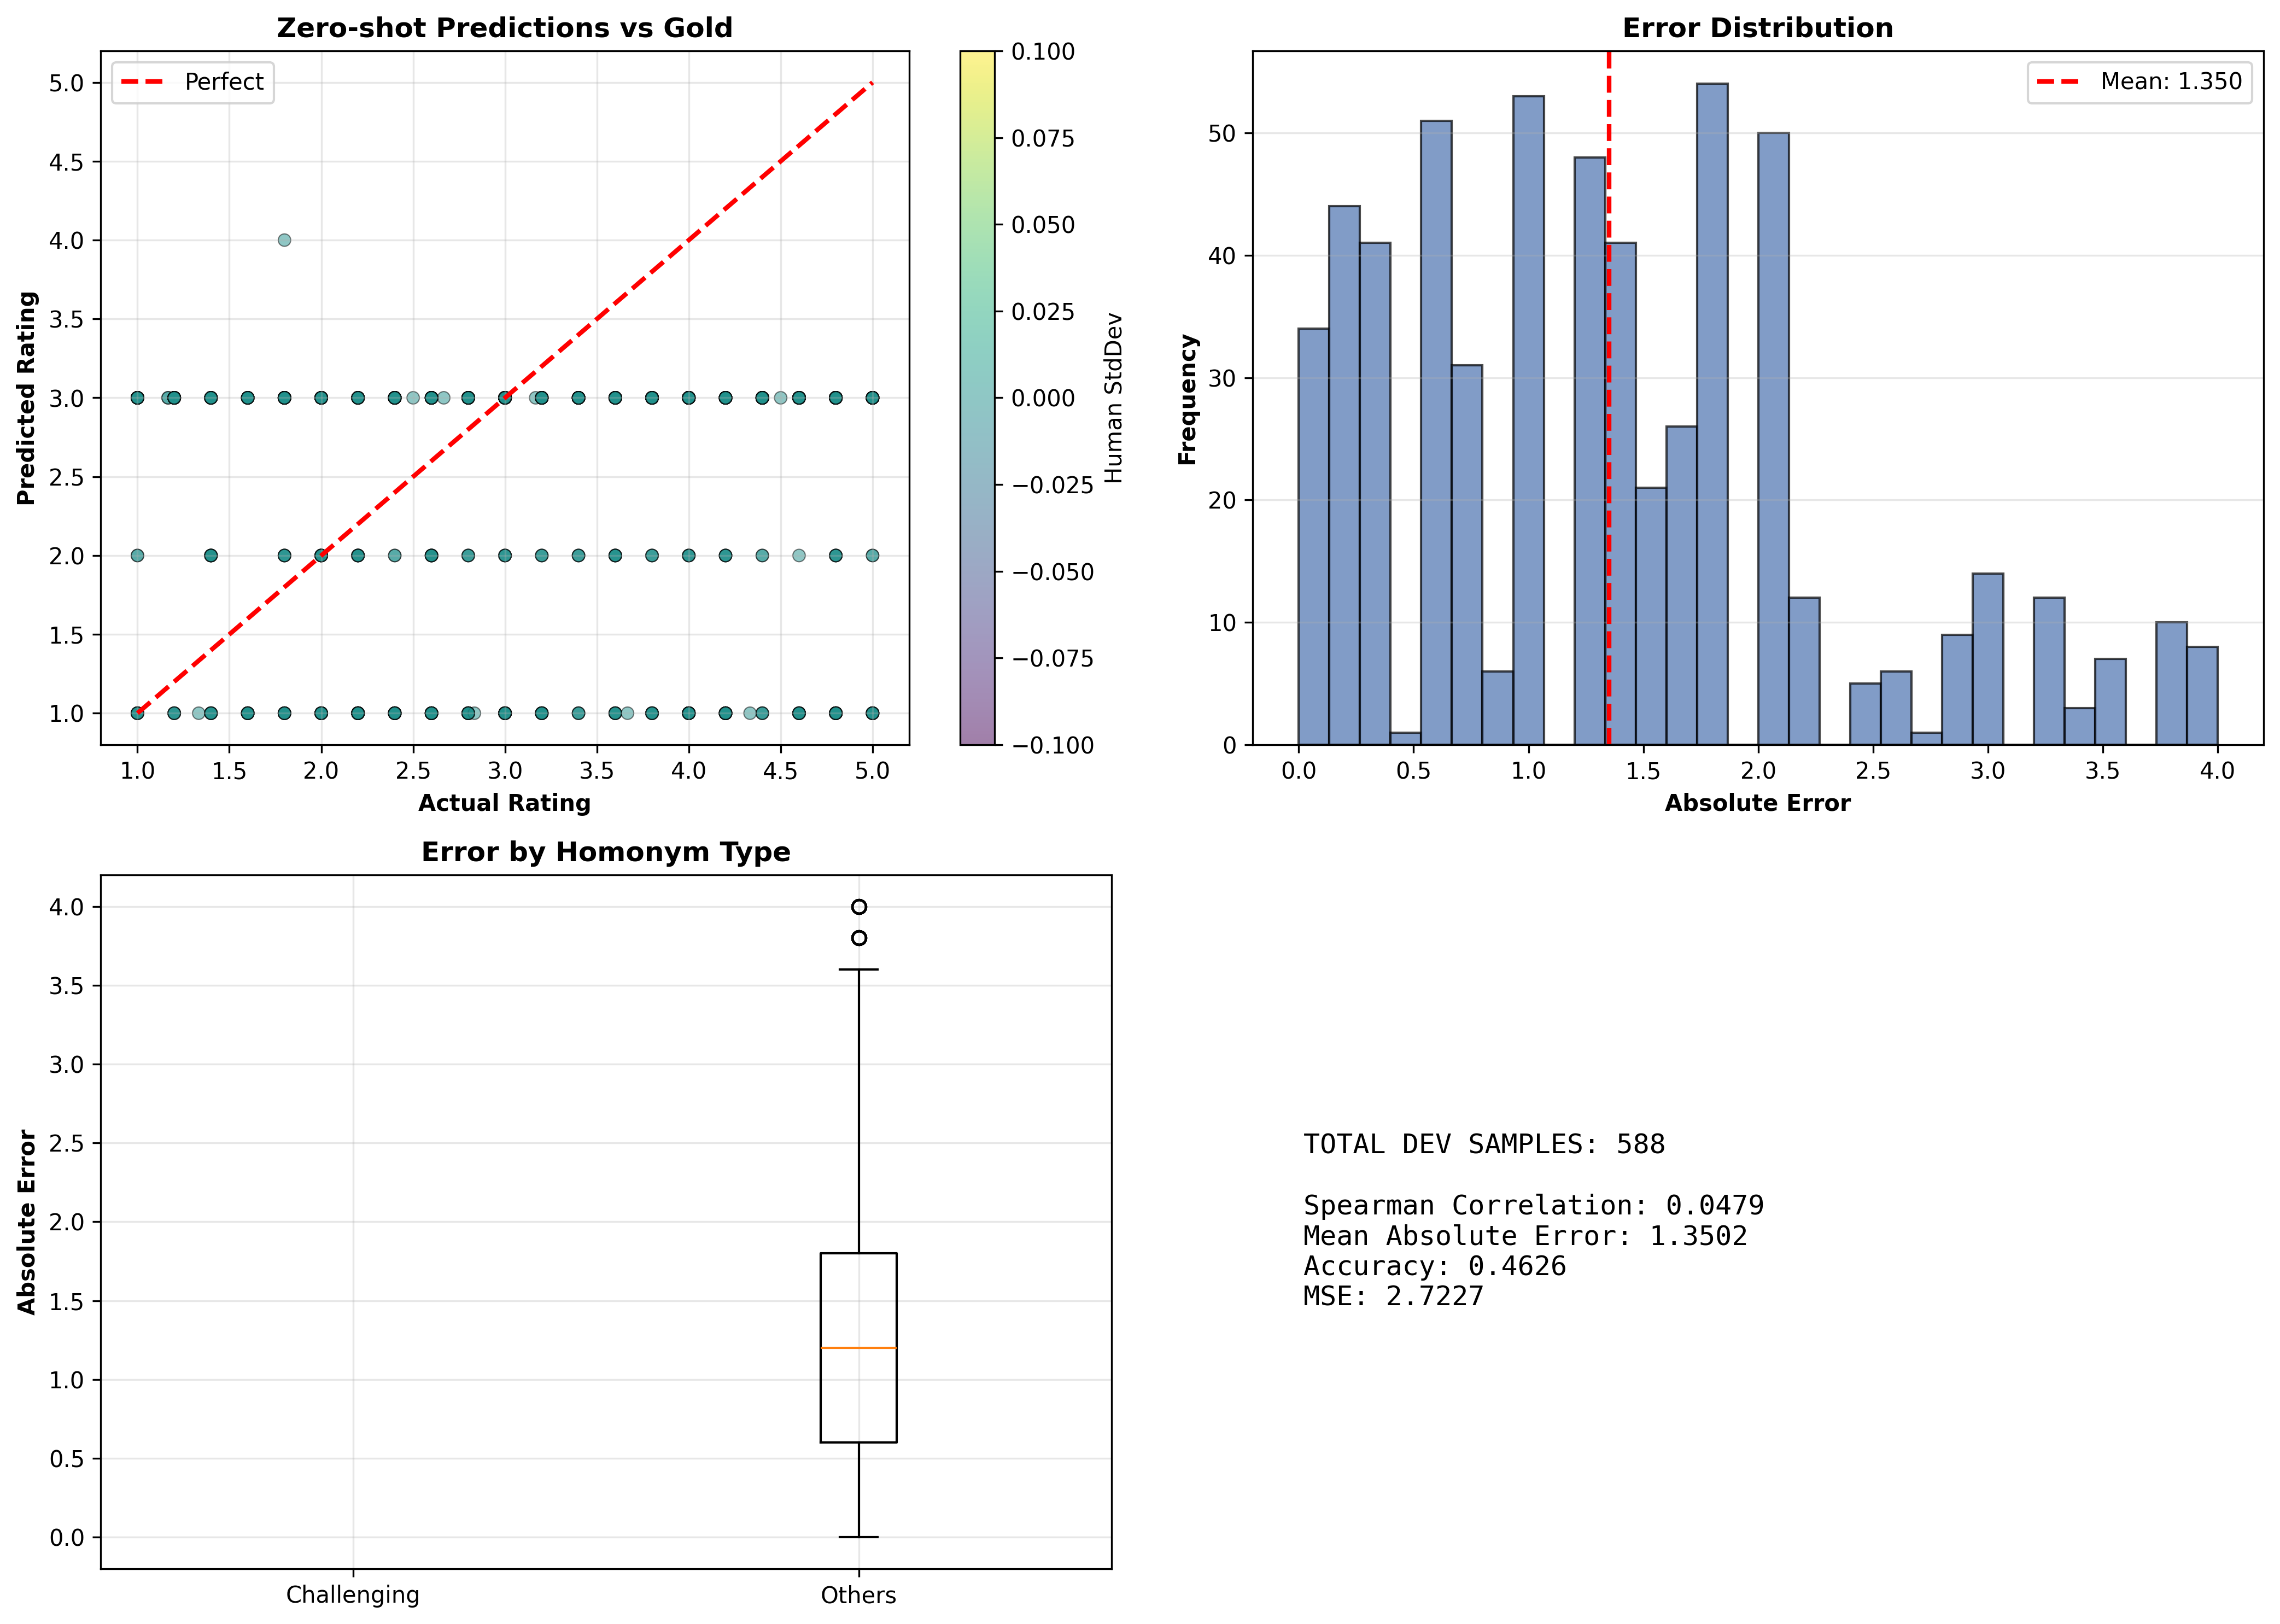

/tmp/ipython-input-1325784111.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot([challenging_errors, other_errors], labels=['Challenging','Others'])


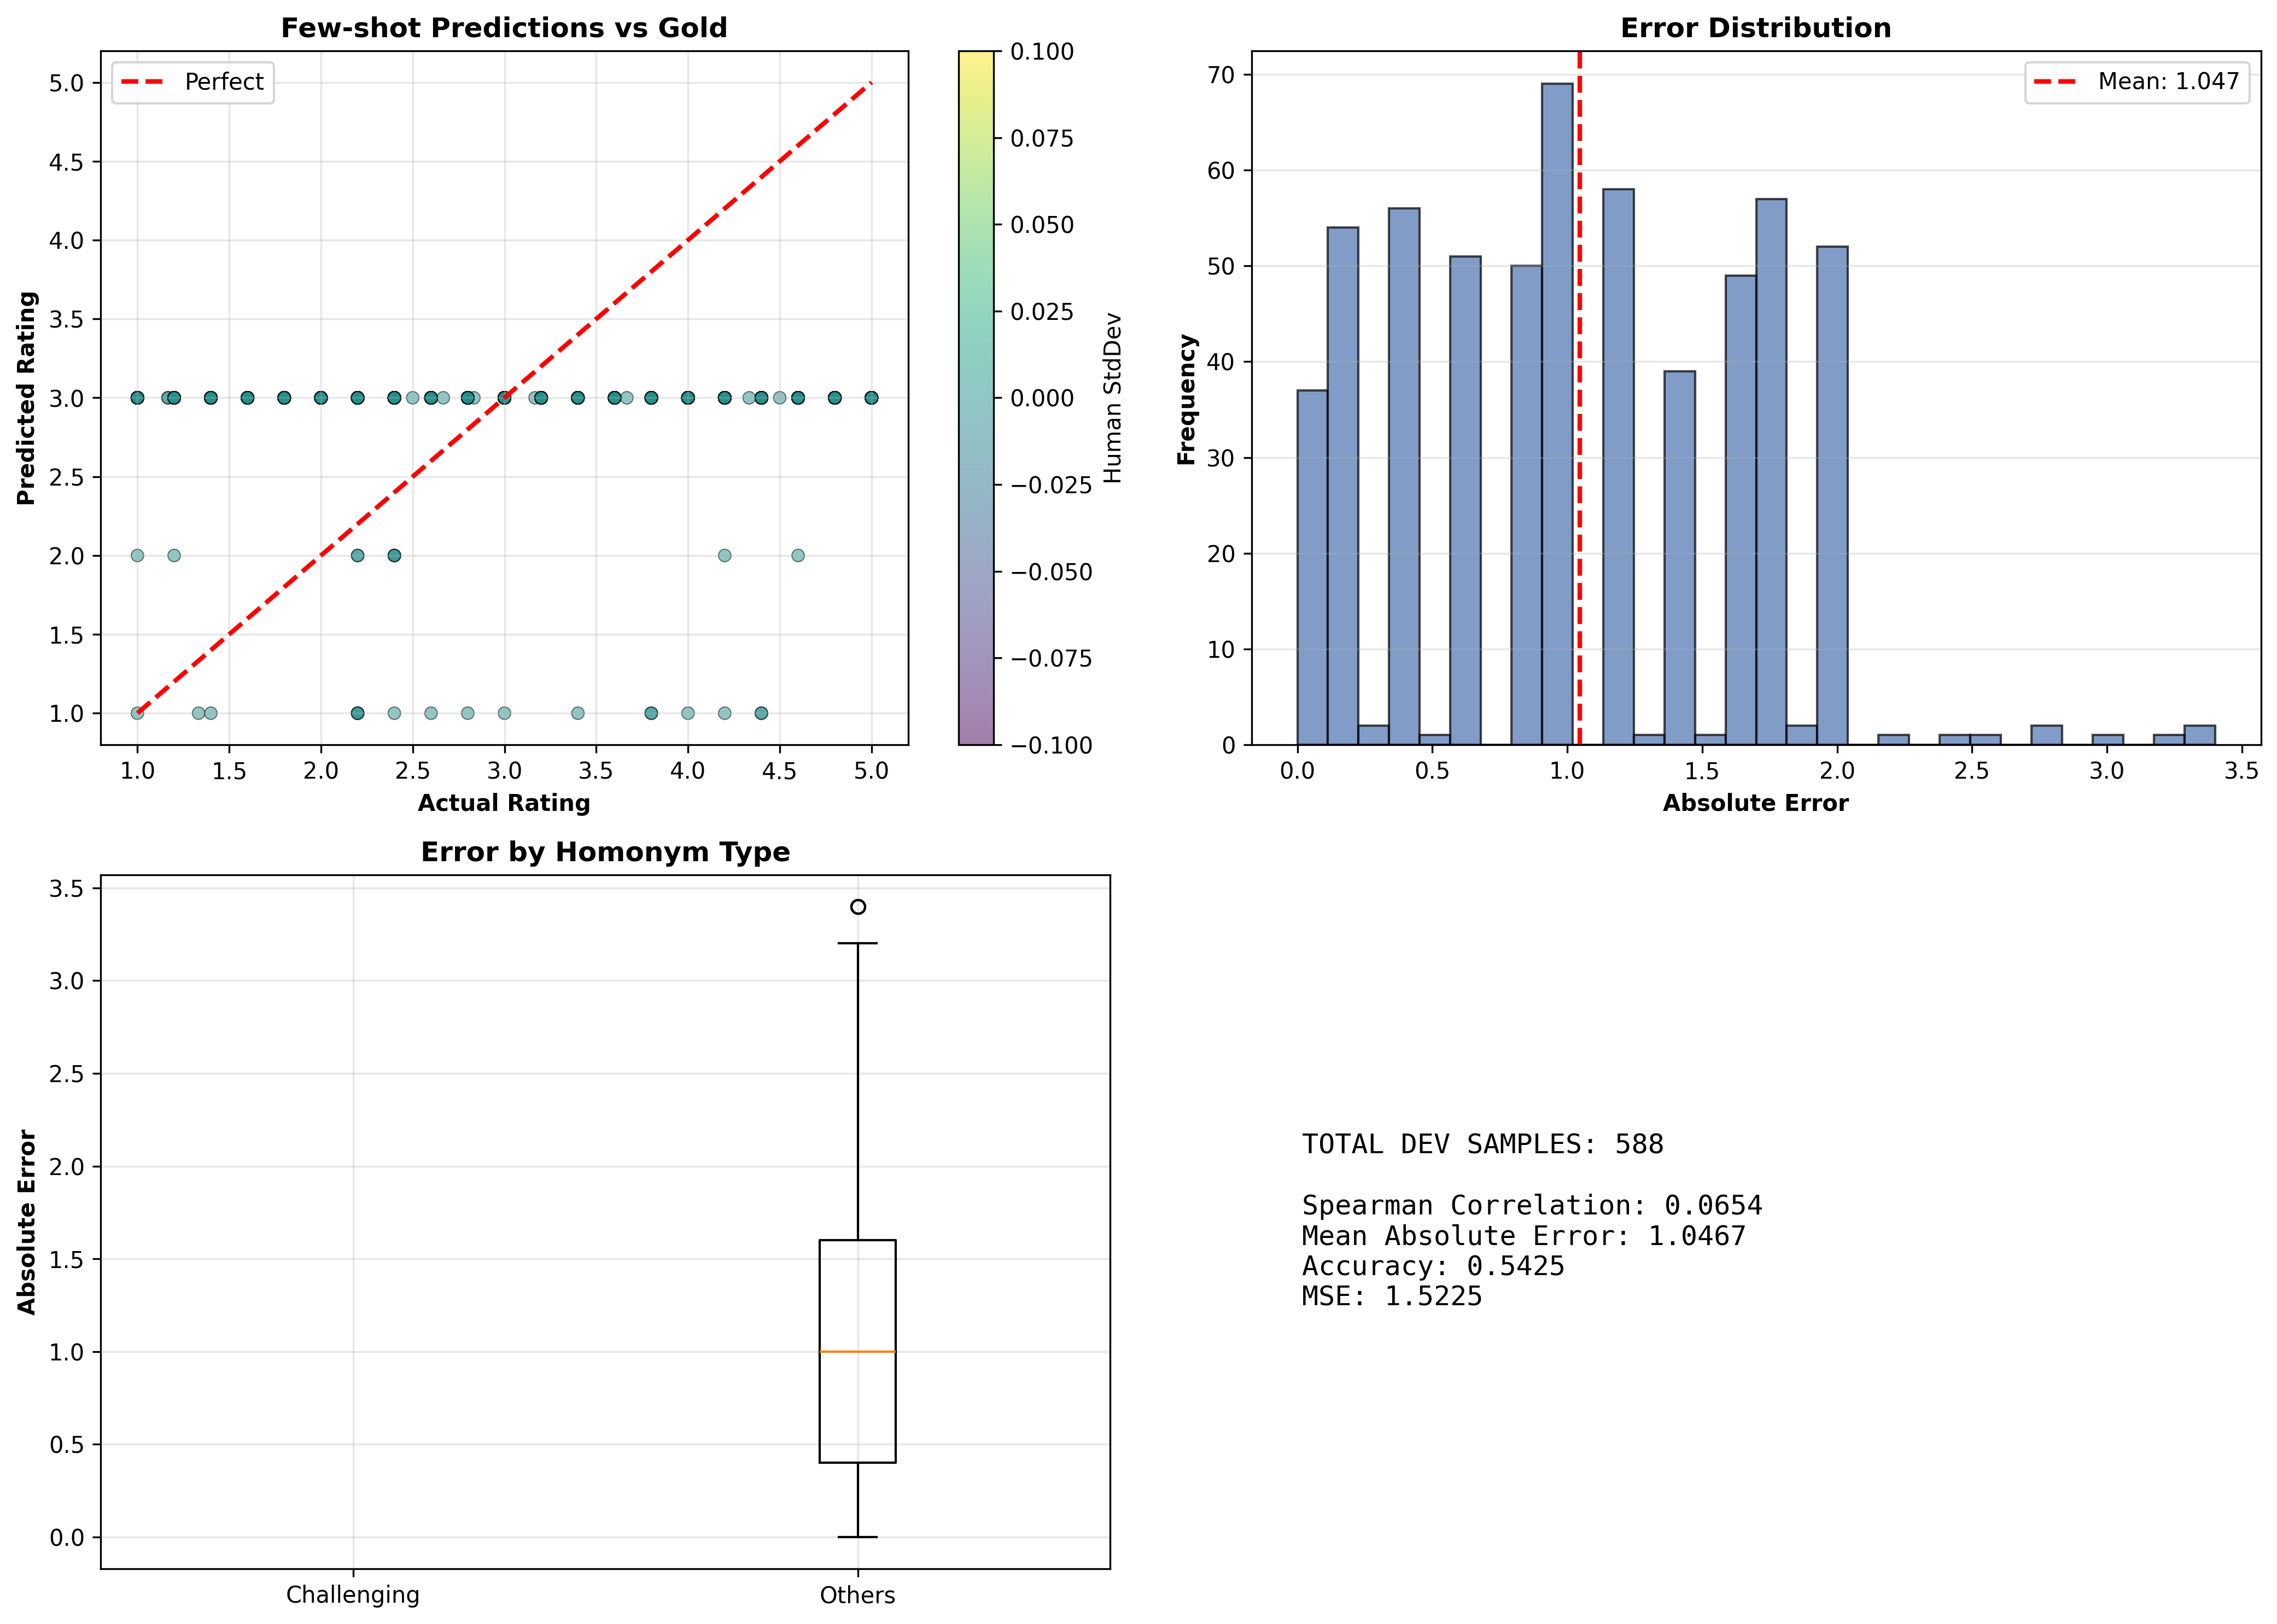

In [ ]:
plot_results(zero_shot_predictions, dev_data, title="Zero-shot Predictions vs Gold",
             save_path="plots/zero_shot_results.png",
             spearman=corr_zs, accuracy=acc_zs, mse=mse_zs, mae=mae_zs)

plot_results(few_shot_predictions, dev_data, title="Few-shot Predictions vs Gold",
             save_path="plots/few_shot_results.png",
             spearman=corr_fs, accuracy=acc_fs, mse=mse_fs, mae=mae_fs)
